In [1]:
import sys
import os.path as osp

from copy import deepcopy
import datetime
import os
import pickle
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from multihist import Hist1d, Histdd
from tqdm.notebook import tqdm
import pandas as pd
from scipy import stats

import strax
import straxen
strax.utils.tqdm = tqdm  # use notebook-aware progress bar

In [2]:
import peaks_utility as psu

In [3]:
st = straxen.contexts.xenonnt_online()

In [ ]:
runs = st.select_runs(run_id='0086*',available=['peak_basics'])
runs

In [4]:
def peakplots(run_name):
    #run_name = runs.iloc[runnumber]['name']
    #print('Run',run_name)
    peak_basics = st.get_array(run_name,'peak_basics',seconds_range=(0,30),
                              selection_str='n_channels>3')

    # risetime
    plt.figure(1)
    psu.plot_area_risetime(peak_basics,0,5,1,5)
    #plt.axvline(x=100, ymin=0.2, ymax=0.29, linestyle="-", color = 'r', label='S1/S2 strax boundary')
    #plt.axhline(y=150, xmin=0.4, xmax=1, linestyle="-", color = 'r')
    #plt.axhline(y=60, xmin=0, xmax=0.4, linestyle="-", color = 'r')
    #plt.legend()

    # width
    plt.figure(2)
    psu.plot_area_width(peak_basics,0,5,1,5)
    psu.rectangle((50,5000),(80,200),'b')
    #ps1.rectangle((400,3500),(80,250),'blue')
    plt.text(100, 100, 'S1', fontsize=18, color='b')
    plt.text(10000, 3000, 'S2', fontsize=18, color='r')
    plt.text(7, 300, 'single electrons', fontsize=12, color='r')

    #length
    plt.figure(3)
    phle = Histdd(peak_basics['area'], peak_basics['length']*peak_basics['dt'],
                        bins=(np.logspace(0, 5, 200), np.logspace(1.7, 4.5, 150)))
    plt.figure(figsize=(12,6))
    phle.plot(log_scale=True, cblabel='events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak length (ns)", ha='right', y=1)
    plt.xscale('log')
    plt.yscale('log')
    # max pmt
    plt.figure(4)
    psu.plot_area_maxpmt(peak_basics,0,5,-0.5,2.3)
    
    # fraction top
    plt.figure(5)
    psu.plot_area_top(peak_basics,0,5,-2,0.1)
    
    # area
    plt.figure(6)
    plt.figure(figsize=(12,6))
    peak_s1 = peak_basics[(peak_basics['rise_time']<150)]
    psu.plot_area(peak_basics)
    psu.plot_area(peak_s1)
    #peak_cut = peak_s1[(peak_s1['max_pmt_area']/peak_s1['area']>0.04)]
    #ps1.plot_area(peak_cut)

<Figure size 432x288 with 0 Axes>

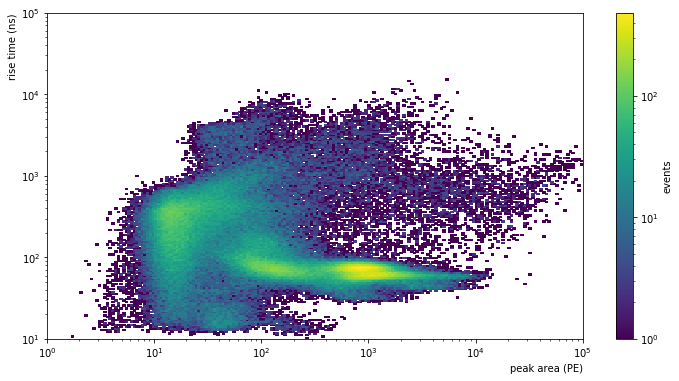

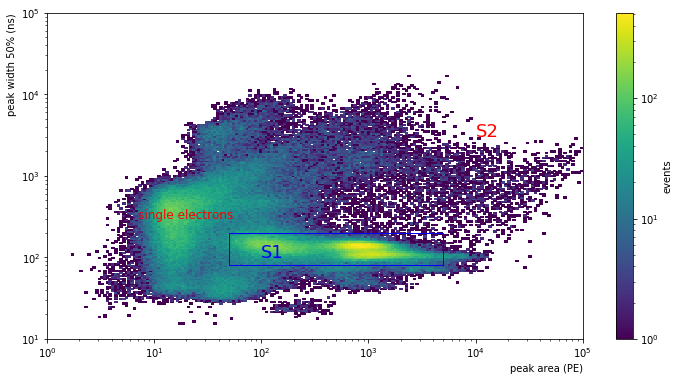

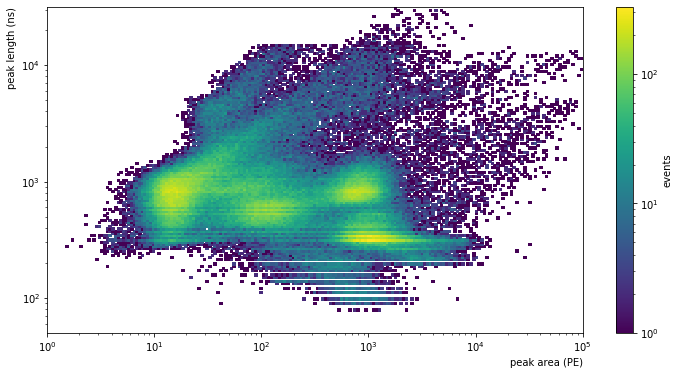

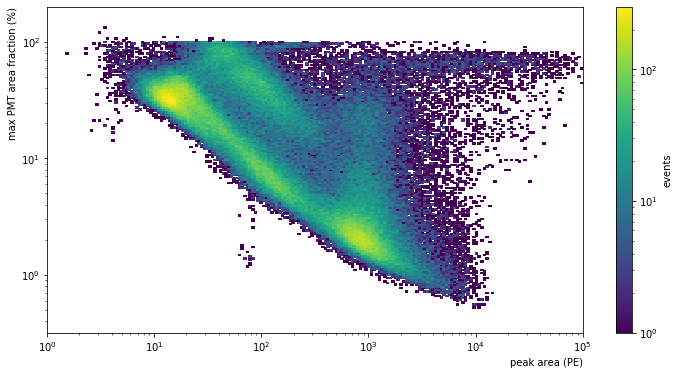

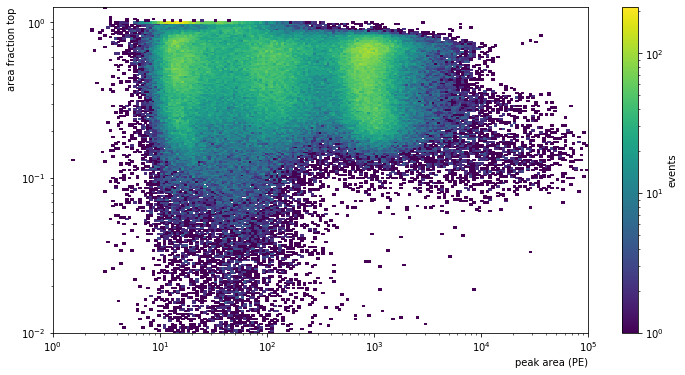

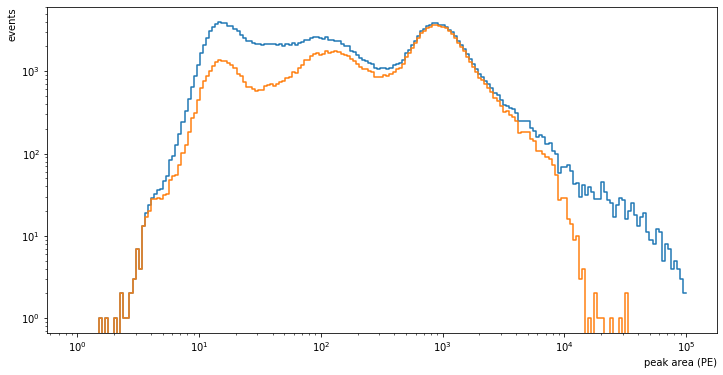

In [5]:
peakplots('008600')

<Figure size 432x288 with 0 Axes>

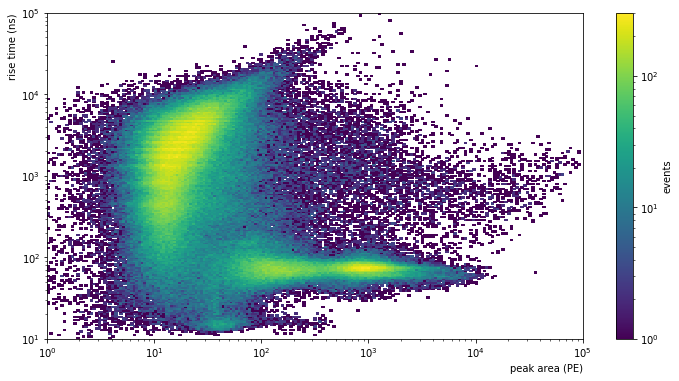

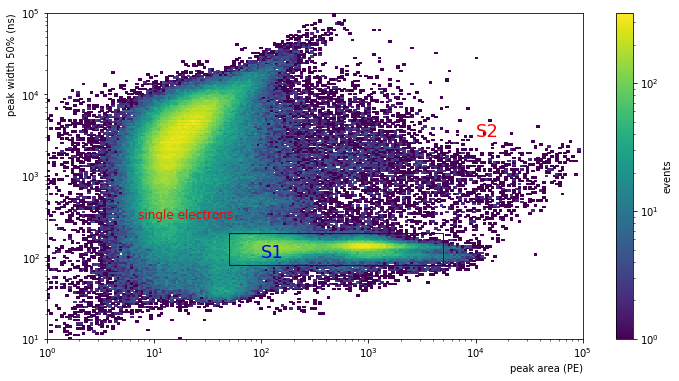

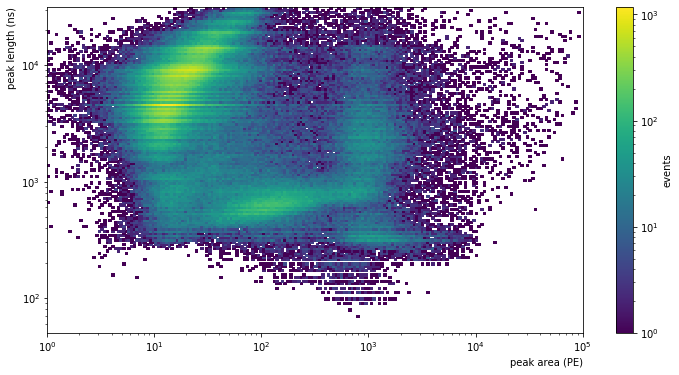

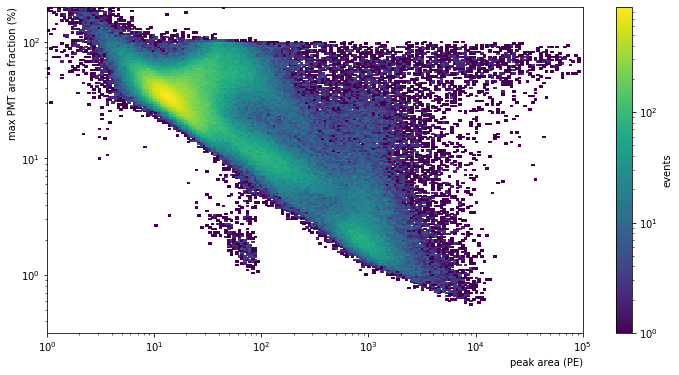

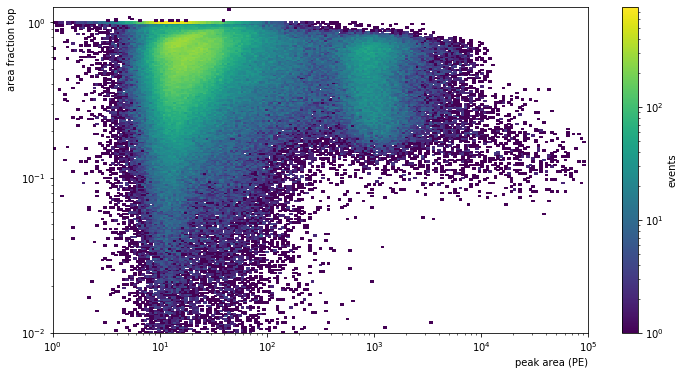

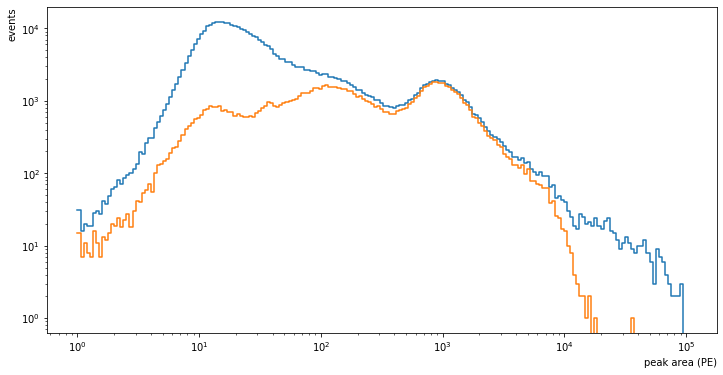

In [6]:
peakplots('008604')

<Figure size 432x288 with 0 Axes>

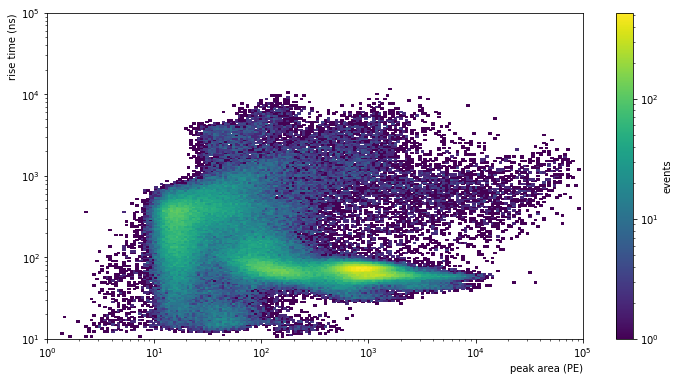

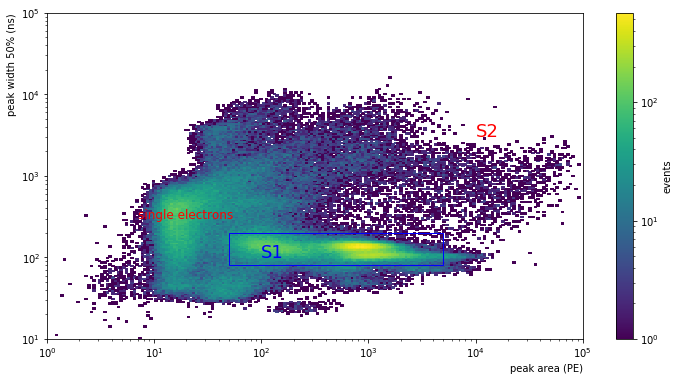

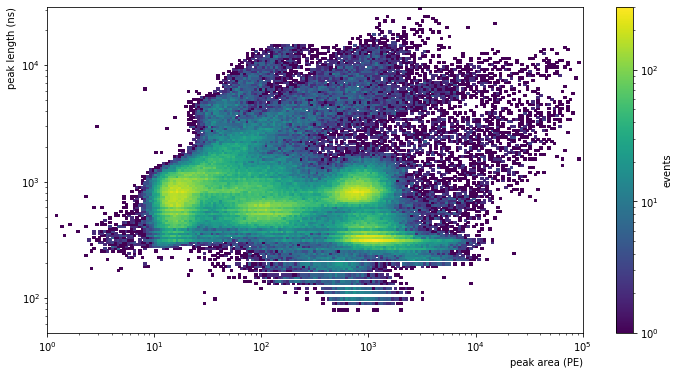

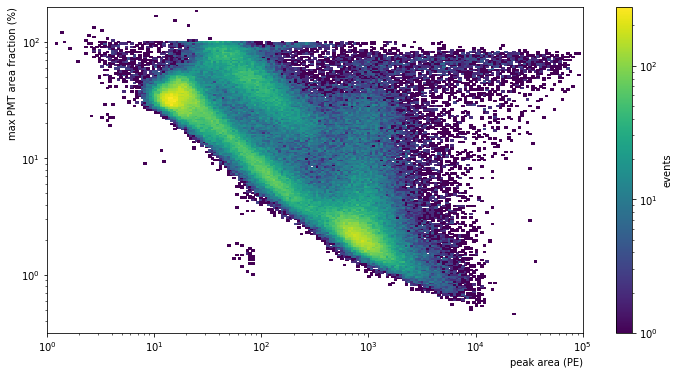

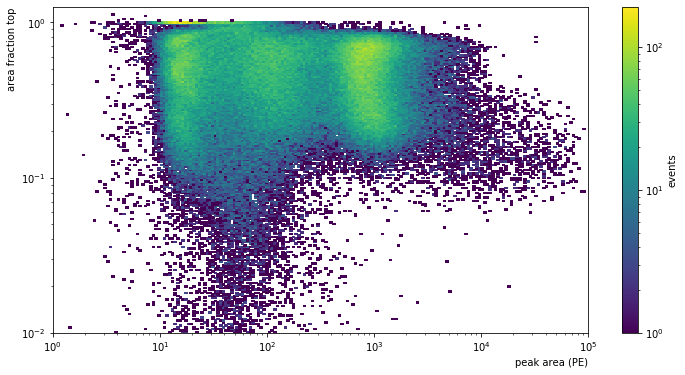

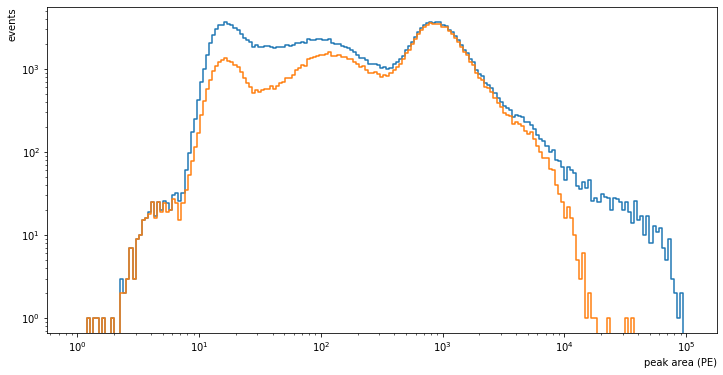

In [7]:
peakplots('008614')

Text(7, 300, 'single electrons')

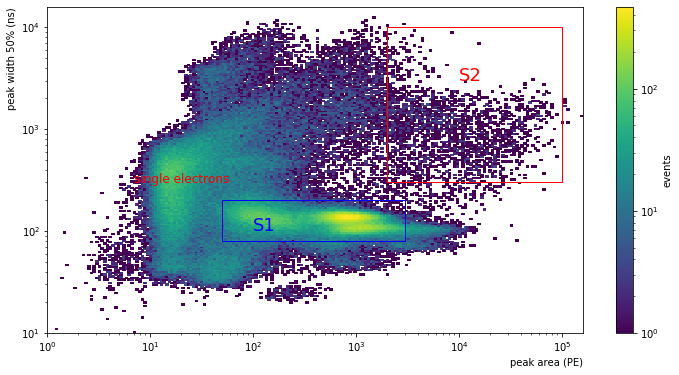

In [8]:
peak_basics = st.get_array('008614','peak_basics',seconds_range=(0,30),
                              selection_str='n_channels>3')
psu.plot_area_width(peak_basics,0,5.2,1,4.2)
plt.text(100, 100, 'S1', fontsize=18, color='b')
area_bounds1=(50,3000)
width_bounds1=(80,200)
area_bounds2=(2000,1e5)
width_bounds2=(300,1e4)
psu.rectangle(area_bounds1,width_bounds1,'b')
plt.text(10000, 3000, 'S2', fontsize=18, color='r')
psu.rectangle(area_bounds2,width_bounds2,'r')
plt.text(7, 300, 'single electrons', fontsize=12, color='r')

## Definition of parameter F90

S1 events in GXe are expected to be slower than LXe, we introduced the **discrimination parameterF90**, which is defined as the  peak area fraction in the first 90 ns. This parameter can help identifying different event populations, i.e. separate beta/gamma events from alpha events


In [ ]:
peaks = st.get_array('008556',['peaks','peak_basics'],seconds_range=(0,30))

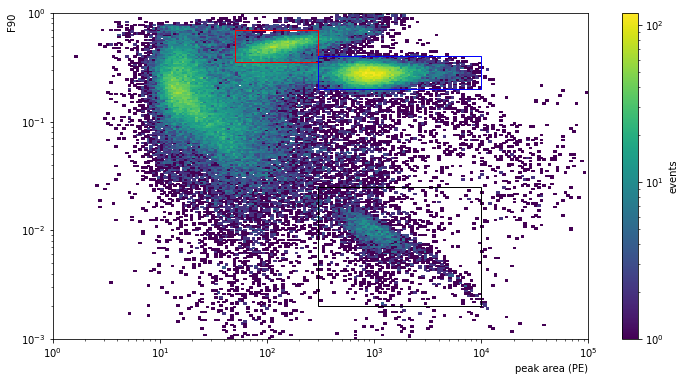

In [10]:
f90 = psu.f90(peaks,0,5,-3,0)
area_cut1 = (50,300)
area_cut2 = (300,1e4)
area_cut3 = (300,1e4)
f90_cut1 = (0.35,0.7)
f90_cut2 = (0.2,0.4)
f90_cut3 = (0.002,0.025)
psu.rectangle(area_cut1,f90_cut1,'r')
psu.rectangle(area_cut2,f90_cut2,'b')
psu.rectangle(area_cut3,f90_cut3,'k')

In [11]:
peaks_cut1 = peaks[(f90<f90_cut1[1]) & (f90>f90_cut1[0])
                   & (peaks['area']>area_cut1[0])]
peaks_cut2 = peaks[(f90<f90_cut2[1]) & (f90>f90_cut2[0])
                   & (peaks['area']>area_cut2[0])
                   & (peaks['area']<area_cut2[1])]
peaks_cut3 = peaks[(f90<f90_cut3[1]) & (f90>f90_cut3[0])
                   & (peaks['area']>area_cut3[0])
                   & (peaks['area']<area_cut3[1])]

total number of records 11805
total number of records 20431
total number of records 3486


<Figure size 432x288 with 0 Axes>

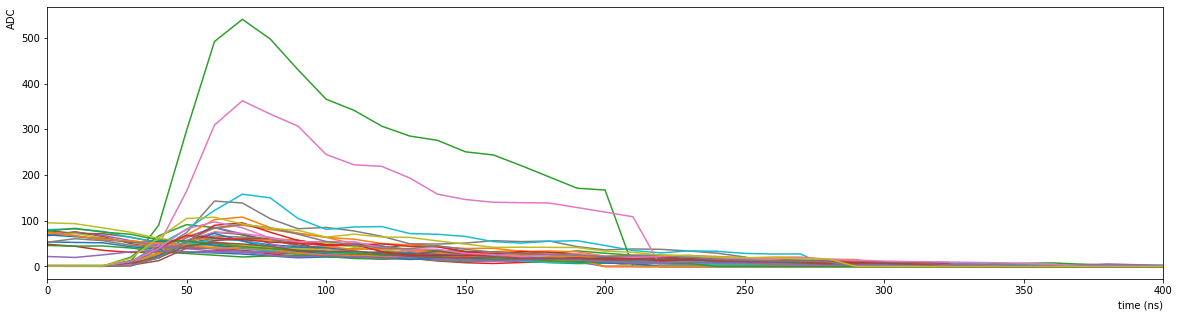

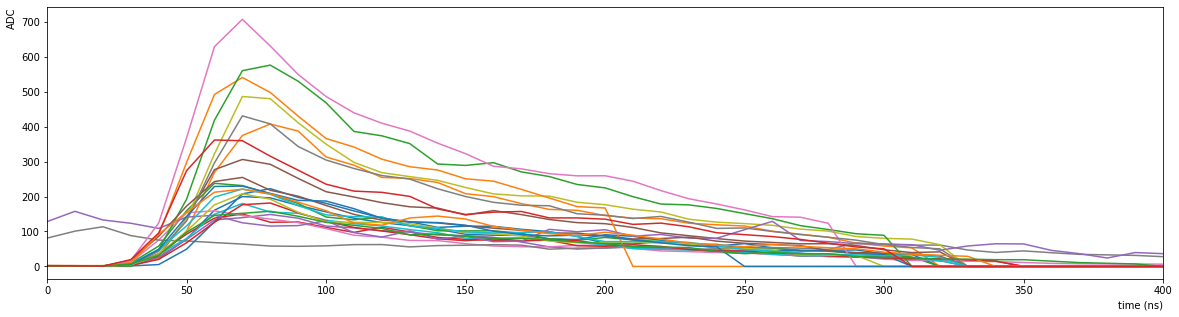

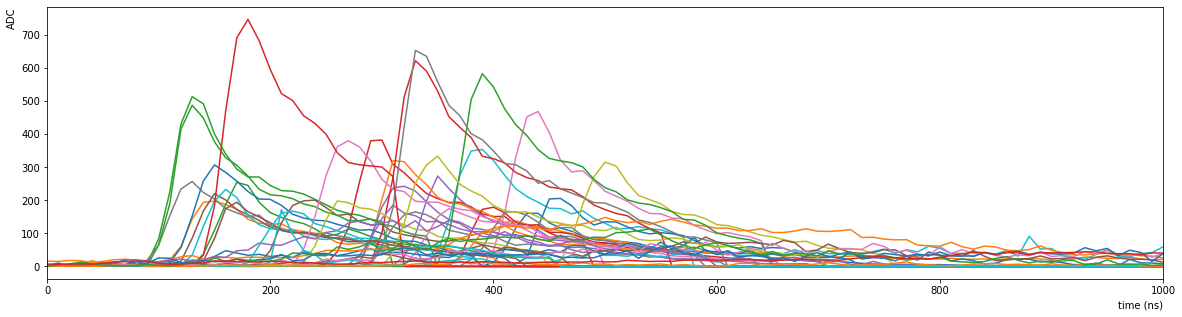

In [15]:
plt.figure(1)
psu.plotwf(peaks_cut1,300,500,10000,400)
plt.figure(2)
psu.plotwf(peaks_cut2,300,2000,10000,400)
plt.figure(3)
psu.plotwf(peaks_cut3,300,2000,10000,1000)

## Prevent S1 splits (from [Joran note](https://github.com/XENONnT/analysiscode/blob/master/Fast_Response_Analysis/S1_peaks/Prevent_S1_splits.ipynb))

Jorana ha implemetato la modifica su run 008637, i dettagli sono in [questa nota](https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenonnt:analysis:meetings:peak_splitting_gxe)

In [4]:
run_id = '008637'

In [5]:
peaks_before = st.get_array(run_id,['peaks','peak_basics'],seconds_range=(0,30))

In [6]:
peak_split_gof_threshold=(
    None,  # Reserved
    ((0.5, 1), (4, 0.4)), # These are the params changed
    ((2, 1), (4.5, 0.4)))
st2 = straxen.contexts.xenonnt_online()
st2.set_config(config=dict(peak_split_gof_threshold=peak_split_gof_threshold))

In [7]:
peaks_after = st2.get_array(run_id, ['peaks','peak_basics'], seconds_range=(0,30),
                                config=dict(peak_split_gof_threshold=peak_split_gof_threshold))

total number of records 205602
total number of records 169695


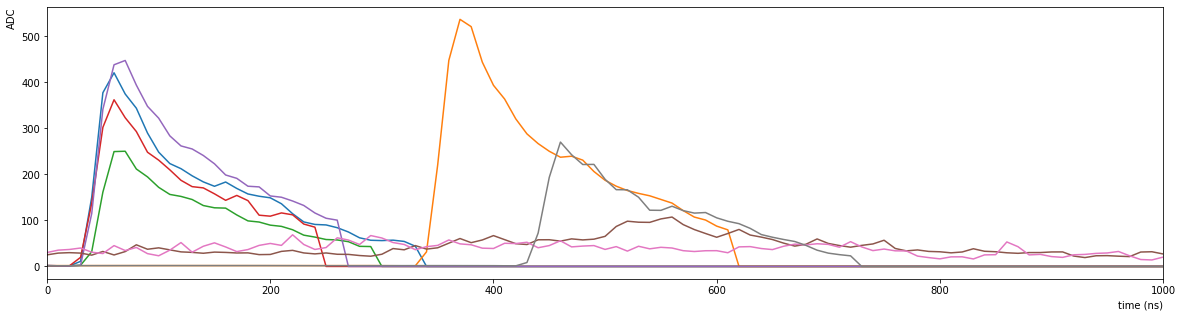

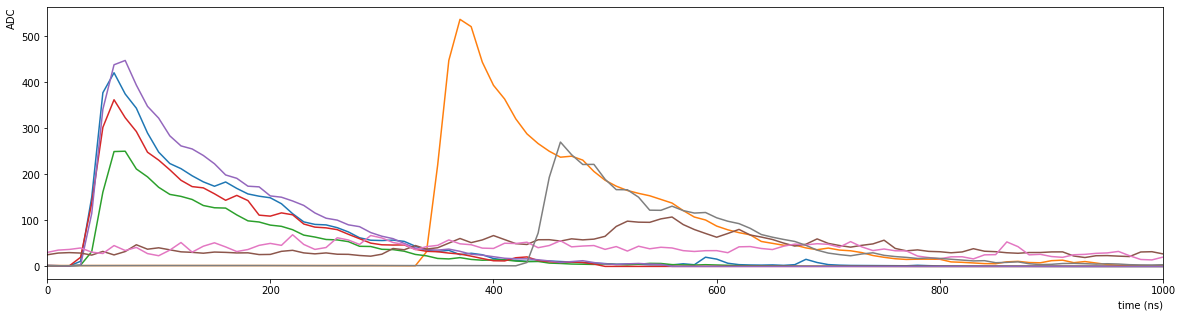

In [8]:
psu.plotwf(peaks_before,500,3000,10000,1000)
psu.plotwf(peaks_after,500,3000,10000,1000)

<Figure size 432x288 with 0 Axes>

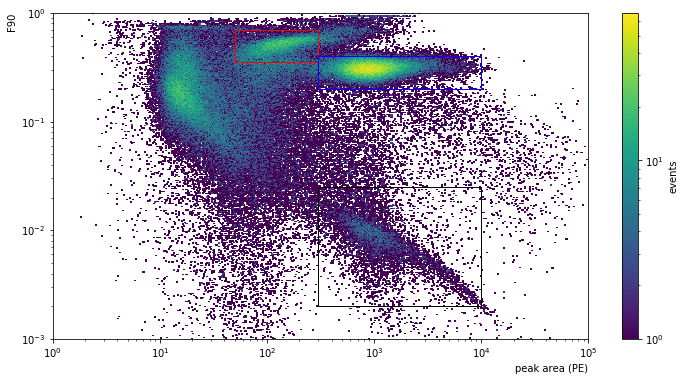

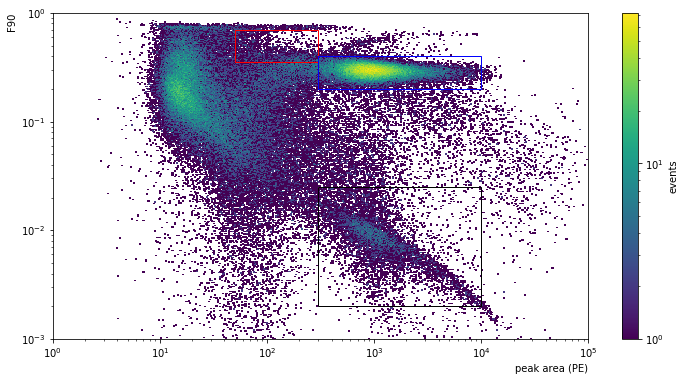

In [9]:
plt.figure(1)
f90_before = psu.f90(peaks_before,0,5,-3,0)
area_cut1 = (50,300)
area_cut2 = (300,1e4)
area_cut3 = (300,1e4)
f90_cut1 = (0.35,0.7)
f90_cut2 = (0.2,0.4)
f90_cut3 = (0.002,0.025)
psu.rectangle(area_cut1,f90_cut1,'r')
psu.rectangle(area_cut2,f90_cut2,'b')
psu.rectangle(area_cut3,f90_cut3,'k')
plt.figure(2)
f90_after = psu.f90(peaks_after,0,5,-3,0)
area_cut1 = (50,300)
area_cut2 = (300,1e4)
area_cut3 = (300,1e4)
f90_cut1 = (0.35,0.7)
f90_cut2 = (0.2,0.4)
f90_cut3 = (0.002,0.025)
psu.rectangle(area_cut1,f90_cut1,'r')
psu.rectangle(area_cut2,f90_cut2,'b')
psu.rectangle(area_cut3,f90_cut3,'k')

<Figure size 432x288 with 0 Axes>

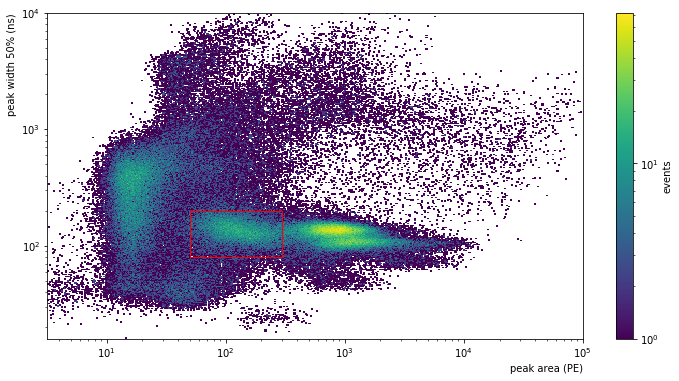

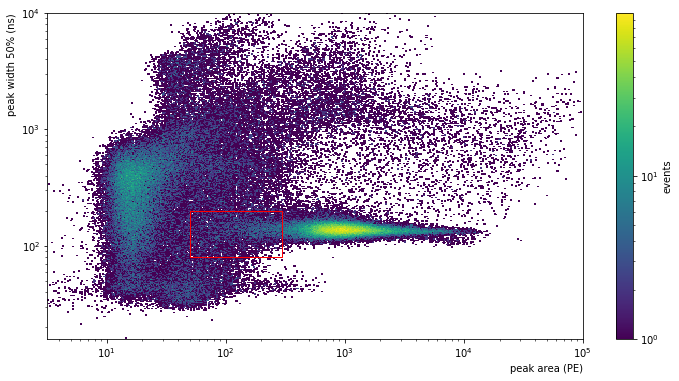

In [10]:
plt.figure(1)
psu.plot_area_width(peaks_before,0.5,5,1.2,4)
psu.rectangle(area_cut1,(80,200),'r')
plt.figure(2)
psu.plot_area_width(peaks_after,0.5,5,1.2,4)
psu.rectangle(area_cut1,(80,200),'r')

<Figure size 432x288 with 0 Axes>

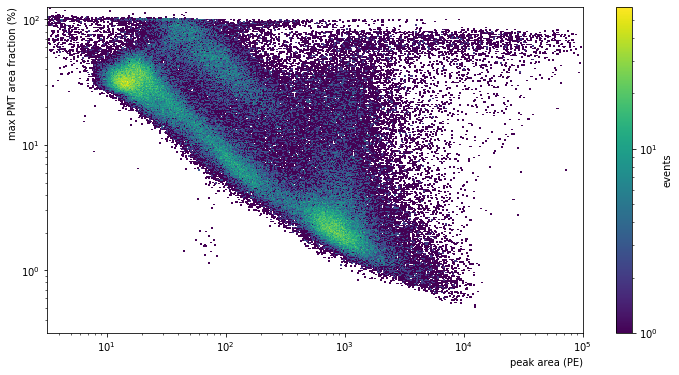

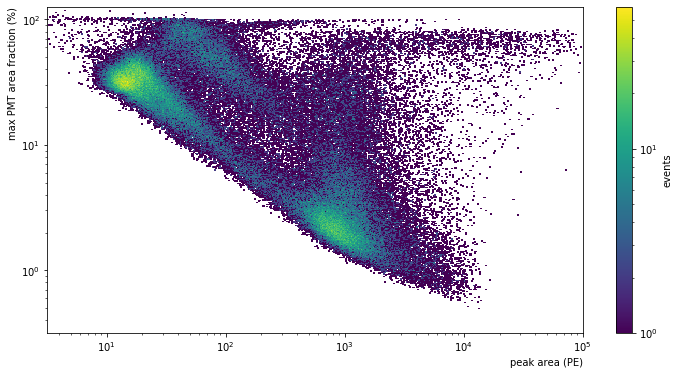

In [11]:
plt.figure(1)
psu.plot_area_maxpmt(peaks_before,0.5,5,-0.5,2.1)
plt.figure(2)
psu.plot_area_maxpmt(peaks_after,0.5,5,-0.5,2.1)

<Figure size 432x288 with 0 Axes>

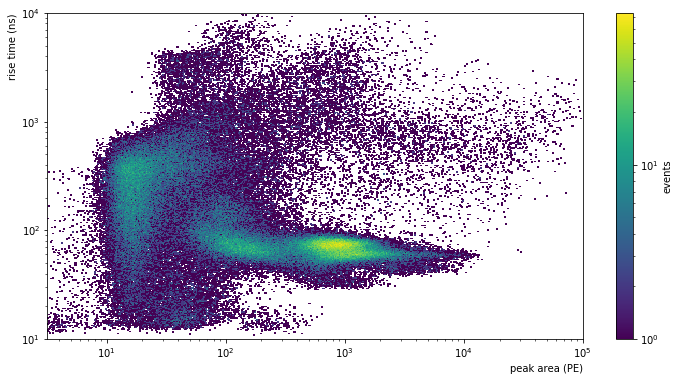

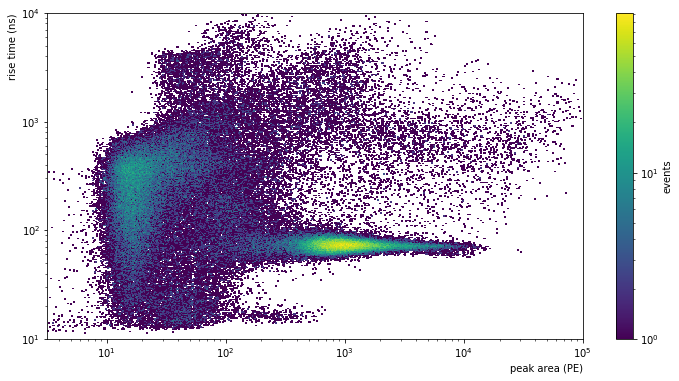

In [14]:
plt.figure(1)
psu.plot_area_risetime(peaks_before,0.5,5,1,4)
plt.figure(2)
psu.plot_area_risetime(peaks_after,0.5,5,1,4)